# AAV conversion

Notes:

1. Have both singlets and GFP+ (GFP vs. mRuby2 gate)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.ticker import ScalarFormatter
from pathlib import Path
import re
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import rushd as rd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib
from scipy.optimize import curve_fit

# Required descriptors for annotate
from statannotations.stats.StatTest import StatTest
from scipy.stats import ttest_ind

# 4 dpi

## Load data

In [2]:
# Directories
base_datadir = rd.datadir/'2024.08.05_AAV-MOI-single_4dpi'
figpath = '../figures/fig3/'


    # Load as df and note header is on 0th row
df_singlets = rd.flow.load_csv_with_metadata(
    base_datadir/'export_singlets', base_datadir/'well_metadata.yaml')
df_GFP = rd.flow.load_csv_with_metadata(
    base_datadir/'export_GFP+', base_datadir/'well_metadata.yaml')

# Convert list of dfs into single df
df_singlets['gate'] = 'singlets'
df_GFP['gate'] = 'GFP+'
df_singlets['dpi'] = 4
df_GFP['dpi'] = 4

# Remove negative data
df_singlets = df_singlets.loc[
    (df_singlets['eGFP-A'] > 0) & (df_singlets['mRuby2-A'] > 0)
]
df_GFP = df_GFP.loc[
    (df_GFP['eGFP-A'] > 0) & (df_GFP['mRuby2-A'] > 0)
]

## Look at eGFP

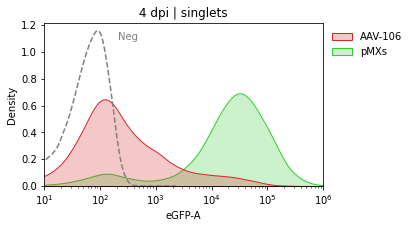

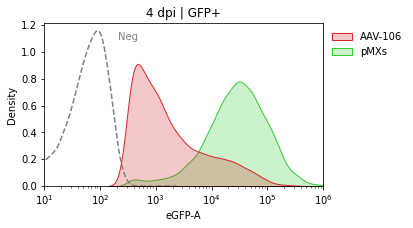

In [3]:
# What to plot
for gate in ['singlets', 'GFP+']:
    if gate == 'singlets':
        df = df_singlets
    elif gate == 'GFP+':
        df = df_GFP

    # Plot eGFP-A
    x = 'eGFP-A'
    hue = 'cond-dose'
    hue_order = ['AAV-106', 'pMXs']
    labels  = ['AAV-106', 'pMXs']
    palette = {
        'AAV-106': 'tab:red', 
        'pMXs': 'limegreen',}

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    f = sns.kdeplot(data=df,
        ax=ax, x=x, hue=hue,
        hue_order=hue_order,
        common_norm=False, log_scale=(True, False),
        palette=palette,
        fill=True)

    # Adjust labels
    sns.move_legend(ax,
        title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

    # Plot neg ctrl
    sns.kdeplot(data=df_singlets[(df_singlets['cond-dose'] == 'Ctrl-neg')], x=x, common_norm=False,
                ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
    ax.annotate('Neg', (0.3, 0.9), color='grey', xycoords='axes fraction', ha='center')
        
    # Adjust limits
    GFP_lim = (10, 1*10**6)
    ax.set_xlim(GFP_lim)

    # Save fig
    ax.set_title(f'4 dpi | {gate}')

What is GFP+ %?

In [4]:
# Calculate GFP+%
group = ['cond-dose']
count_df_reps = df_GFP.groupby([*group, 'well'])[
    'FSC-A'].count().rename('count')
totalcount_df_reps = df_singlets.groupby([*group, 'well'])[
    'FSC-A'].count().rename('count')
GFP_percent_4dpi = (count_df_reps*100/totalcount_df_reps.groupby([*group, 'well']
                           ).transform('sum')).reset_index(name='GFP percent')
totalcount_df_reps = totalcount_df_reps.reset_index(name='Total count')

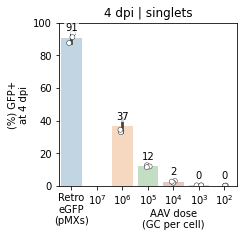

In [5]:
# General plotting params
x = 'cond-dose'
y = 'GFP percent'
order = ['pMXs', 'AAV-107', 'AAV-106', 'AAV-105', 'AAV-104', 'AAV-103', 'AAV-102']
label_dict = {
    'pMXs':'Retro\neGFP\n(pMXs)', 
    'AAV-107': '10$^7$',
    'AAV-106': '10$^6$',
    'AAV-105': '10$^5$',
    'AAV-104': '10$^4$\nAAV dose\n(GC per cell)',
    'AAV-103': '10$^3$',
    'AAV-102': '10$^2$',
}
palette = {
    'pMXs':'tab:blue', 
    'AAV-107': 'tab:pink',
    'AAV-106': 'tab:orange',
    'AAV-105': 'tab:green',
    'AAV-104': 'tab:red',
    'AAV-103': 'tab:purple',
    'AAV-102': 'tab:brown',
}

fig, ax = plt.subplots(1, 1, figsize=(3.2, 3))
# Plot
sns.barplot(
    ax=ax, data=GFP_percent_4dpi,
    x=x, y=y,
    order=order,palette=palette,
    alpha=0.3)

# Plot reps
sns.stripplot(
    ax=ax, data=GFP_percent_4dpi,
    x=x, y=y, 
    order=order,
    dodge=True, marker='o',
    color='white', size=5,
    edgecolor='black', linewidth=0.4)
    
# Label
ax.set_title(f'4 dpi | singlets')
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('(%) GFP+\nat 4 dpi')
ax.set_yticks(np.arange(0, 101, 20))
ax.set_xticklabels([label_dict[label] for label in order])
# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))  

# plt.savefig(figpath + 'SI/4dpi_GFP+_percent.svg', bbox_inches='tight') 

Look at mean values

In [6]:
group = ['cond-dose', 'gate']

x = 'eGFP-A'
df_GFP_gmean = df_GFP.groupby([*group, 'well'])[x].apply(scipy.stats.gmean).reset_index(name=x+' (gmean)')
df_GFP_gmean.loc[:, 'log({})'.format(x+' (gmean)')] = np.log10(df_GFP_gmean[x+' (gmean)'])

Text(0.5, 1.0, '4 dpi | GFP+')

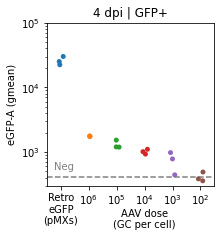

In [7]:
# Plotting params
x = 'cond-dose'
y = 'eGFP-A'

order = ['pMXs', 'AAV-106', 'AAV-105', 'AAV-104', 'AAV-103', 'AAV-102']
label_dict = {
    'pMXs':'Retro\neGFP\n(pMXs)', 
    'AAV-107': '10$^7$',
    'AAV-106': '10$^6$',
    'AAV-105': '10$^5$',
    'AAV-104': '10$^4$\nAAV dose\n(GC per cell)',
    'AAV-103': '10$^3$',
    'AAV-102': '10$^2$',
}

# Plot as box
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

sns.stripplot(ax=ax,
    data=df_GFP_gmean, x=x, y=(y+' (gmean)'),
    order=order)

# Label
ax.set_title(f'4 dpi | GFP+')
ax.xaxis.set_label_text('')
ax.set_xticklabels([label_dict[label] for label in order])
ax.set_yscale('log')
ax.set_ylim((3e2, 10e4))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Add neg
GFP_neg = df_GFP_gmean[df_GFP_gmean['cond-dose']=='Ctrl-neg']['eGFP-A (gmean)'].mean()
ax.axhline(y=GFP_neg, color='grey', linestyle='--')
ax.annotate('Neg', (0.1, 0.1), color='grey', xycoords='axes fraction', ha='center')

plt.title('4 dpi | GFP+')
# plt.savefig(figpath + 'SI/4dpi_GFP-gmean.svg', bbox_inches='tight')

# MOI calculation

## MOI calc from batch 1 on 4/16

In [8]:
# Calculate GFP+%
group = ['cond-dose', 'dosePerCell', 'virusVolPerWell']
count_df_reps = df_GFP.groupby([*group, 'well'])[
    'FSC-A'].count().rename('count')
totalcount_df_reps = df_singlets.groupby([*group, 'well'])[
    'FSC-A'].count().rename('count')
df = (count_df_reps/totalcount_df_reps.groupby([*group, 'well']
                           ).transform('sum')).reset_index(name='GFP percent')

df.dosePerCell = df.dosePerCell.astype(float)             
df['seedNum'] = 2500
df['virusVolPerCell'] = df['virusVolPerWell']/df['seedNum']

Text(0.5, 0, 'Dose (GC/cell)')

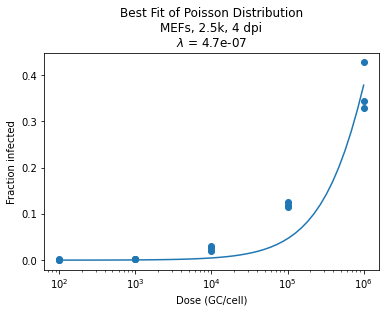

In [9]:
def poisson_model(TUratio, dosePerCell):
    # MOI = TU/GC * GC/cell
    return 1 - np.exp(-TUratio * dosePerCell)


x = 'dosePerCell'
y = 'GFP percent'
popt, _ = curve_fit(
    poisson_model,
    df[x],
    df[y],
    p0=0.1,
    bounds=(0, np.inf),
)

plt.scatter(df[x], df[y])
xmodel = np.geomspace(np.min(df[x]), np.max(df[x]))
plt.plot(xmodel, poisson_model(xmodel, *popt))

plt.title(f"Best Fit of Poisson Distribution\nMEFs, 2.5k, 4 dpi\n$\lambda$ = {popt[0]:.2g}")
plt.xscale("log")
plt.ylabel("Fraction infected")
plt.xlabel("Dose (GC/cell)")

Text(0.5, 0, 'Dose (GC/cell)')

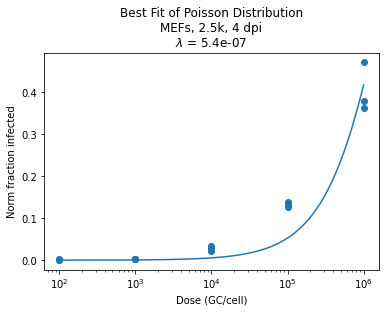

In [10]:
max_infect = GFP_percent_4dpi[GFP_percent_4dpi['cond-dose'] == 'pMXs']['GFP percent'].mean()
df['norm GFP percent'] = df['GFP percent']/(max_infect/100)


x = 'dosePerCell'
y = 'norm GFP percent'
popt2, _ = curve_fit(
    poisson_model,
    df[x],
    df[y],
    p0=0.1,
    bounds=(0, np.inf),
)


plt.scatter(df[x], df[y])
xmodel = np.geomspace(np.min(df[x]), np.max(df[x]))
plt.plot(xmodel, poisson_model(xmodel, *popt2))

plt.title(f"Best Fit of Poisson Distribution\nMEFs, 2.5k, 4 dpi\n$\lambda$ = {popt2[0]:.2g}")
plt.xscale("log")
plt.ylabel("Norm fraction infected")
plt.xlabel("Dose (GC/cell)")


# 14 dpi


## Load data

In [11]:
# Directories
base_datadir = rd.datadir/'2024.09.22_AAV_14dpi'

# Load as df and note header is on 0th row
data_14dpi = rd.flow.load_csv_with_metadata(
    base_datadir/'export_singlets', base_datadir/'well_metadata.yaml')

# Remove negative data
data_14dpi = data_14dpi.loc[(data_14dpi['eGFP-A'] > 0)]

## Look at eGFP

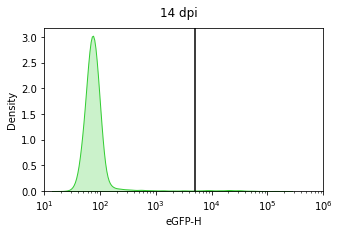

In [12]:
# Threshold for iMNs
eGFP_H_thresh = 5*10**3

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plot eGFP-H
x = 'eGFP-H'
hue = 'cond'

sns.kdeplot(ax=ax, data=data_14dpi.loc[data_14dpi.cond == 'pMXs-LNI + AAV-SDDIR'],
    x=x, color='limegreen',
    common_norm=False, log_scale=(True, False),
    fill=True)

# Title
plt.suptitle('14 dpi')
# Adjust limits
eGFP_lim = (10, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)

sub_ax.axvline(eGFP_H_thresh, 0, 1, color='black')

What is GFP+ %?

In [13]:
# Categorize iMNs based on eGFP_thresh
data_14dpi['eGFP_cat'] = 'fib'
data_14dpi.loc[(data_14dpi['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'iMN'

# Get total counts and percent of eGFP-H+
group = ['cond', 'rep']
count_GFP_df_reps = data_14dpi.groupby([*group, 'eGFP_cat'])['FSC-A'].count().unstack(fill_value=0).stack().rename('iMN count') # Puts 0 if no eGFP-H+ rather than dropping row
count_total_df_reps = data_14dpi.groupby([*group,])['FSC-A'].count().reset_index(name='Total count')
# Calc eGFP +/- percent and merge with counts
percent_GFP_df_reps = (count_GFP_df_reps*100/count_GFP_df_reps.groupby([*group]).transform('sum')).dropna().rename('iMN percent')
GFP_df = pd.merge(percent_GFP_df_reps, count_GFP_df_reps, on=[*group, 'eGFP_cat']).reset_index()
# Calc yield from counts
numSeed = 2.5*1e3
GFP_df['iMN yield'] = GFP_df['iMN count']/numSeed*100
# Get just eGFP+
GFP_df = GFP_df.loc[GFP_df.eGFP_cat == 'iMN']
GFP_df = GFP_df.merge(count_total_df_reps)

## iMN yield and purity

/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position fou

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AAV-LNI vs. AAV-LNI + AAV-SDDIR: t-test independent samples, P_val:2.275e-01 t=-1.424e+00
pMXs-LNI vs. pMXs-LNI + AAV-SDDIR: t-test independent samples, P_val:6.377e-01 t=-5.087e-01
AAV-LNI vs. AAV-LNI + pMXs-SDDIR: t-test independent samples, P_val:1.644e-03 t=-7.556e+00


(<AxesSubplot:title={'center':'14 dpi'}, ylabel='(%) iMN\nof all cells'>,
  <statannotations.Annotation.Annotation at 0x30f4263a0>])

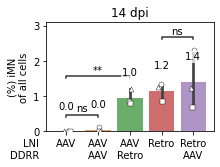

In [14]:
# Plotting params
x = 'cond'
y = 'iMN percent'

order = [
    'AAV-LNI', 'AAV-LNI + AAV-SDDIR',
    'AAV-LNI + pMXs-SDDIR',
    'pMXs-LNI', 'pMXs-LNI + AAV-SDDIR']

label_dict = {
    'AAV-LNI': 'LNI (AAV)',
    'AAV-LNI + AAV-SDDIR': 'LNI\n(AAV)\nSDDIR\n(AAV)',
    'AAV-LNI + pMXs-SDDIR': 'LNI (AAV)\nSDDIR (retro)',
    'pMXs-LNI':'LNI (retro)',
    'pMXs-LNI + AAV-SDDIR': 'LNI (retro)\nSDDIR (AAV)'}


marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

# Plot as box
sns.barplot(ax=ax,
    data=GFP_df, 
    x=x, y=y,
    order=order, alpha=0.75)

for (i, rep) in enumerate(GFP_df.rep.unique()):
    sns.stripplot(
        ax=ax, data=GFP_df[GFP_df.rep == rep],
        x=x, y=y, 
        order=order,
        dodge=True, marker=marker_list[i],
        color='white', size=5,
        edgecolor='black', linewidth=0.4)
    
# Format
ax.set_xlabel('')
ax.yaxis.set_label_text('(%) iMN\nof all cells')
plt.title('14 dpi')
ax.set_yticks(np.arange(0, 3.1, 1))

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.1f', padding=20)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

df_labels = pd.DataFrame({
    "cond": ['AAV-LNI', 'AAV-LNI + AAV-SDDIR', 'AAV-LNI + pMXs-SDDIR', 'pMXs-LNI', 'pMXs-LNI + AAV-SDDIR'],
    "LNI": ["AAV",  "AAV",   "AAV",  "Retro",    "Retro"],
    "DDRR": ["",    "AAV", "Retro",       "",      "AAV"],
})
rd.plot.generate_xticklabels(df_labels=df_labels, ax_col=x, label_cols=["LNI", "DDRR"], ax=ax)  

# Add in stats
# Pairs for stats comp
pairs = [
    ('AAV-LNI', 'AAV-LNI + pMXs-SDDIR',),
    ('AAV-LNI', 'AAV-LNI + AAV-SDDIR',),
    ('pMXs-LNI', 'pMXs-LNI + AAV-SDDIR'),
]
annot = Annotator(ax=ax,
    data=GFP_df, pairs=pairs,
    x=x, y=y,
    order=order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)


# plt.savefig(figpath + '14dpi_iMN-purity.svg', bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AAV-LNI vs. AAV-LNI + AAV-SDDIR: t-test independent samples, P_val:2.533e-01 t=-1.333e+00
pMXs-LNI vs. pMXs-LNI + AAV-SDDIR: t-test independent samples, P_val:1.843e-01 t=-1.603e+00
AAV-LNI vs. AAV-LNI + pMXs-SDDIR: t-test independent samples, P_val:1.903e-02 t=-3.804e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position fou

(<AxesSubplot:title={'center':'14 dpi'}, ylabel='(%) iMN yield\nper MEF plated'>,
  <statannotations.Annotation.Annotation at 0x30f3f0bb0>])

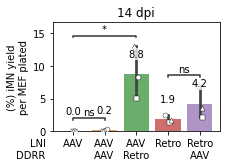

In [15]:
# Plotting params
x = 'cond'
y = 'iMN yield'

order = [
    'AAV-LNI', 'AAV-LNI + AAV-SDDIR',
    'AAV-LNI + pMXs-SDDIR',
    'pMXs-LNI', 'pMXs-LNI + AAV-SDDIR']

label_dict = {
    'AAV-LNI': 'LNI (AAV)',
    'AAV-LNI + AAV-SDDIR': 'LNI (AAV)\nSDDIR (AAV)',
    'AAV-LNI + pMXs-SDDIR': 'LNI (AAV)\nSDDIR (retro)',
    'pMXs-LNI':'LNI (retro)',
    'pMXs-LNI + AAV-SDDIR': 'LNI (retro)\nSDDIR (AAV)'}


marker_list = ['o', 's', '^', 'D', 'P', 'X']

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

# Plot as box
sns.barplot(ax=ax,
    data=GFP_df, 
    x=x, y=y,
    order=order, alpha=0.75)

for (i, rep) in enumerate(GFP_df.rep.unique()):
    sns.stripplot(
        ax=ax, data=GFP_df[GFP_df.rep == rep],
        x=x, y=y, 
        order=order,
        dodge=True, marker=marker_list[i],
        color='white', size=5,
        edgecolor='black', linewidth=0.4)
    
# Format
ax.set_xlabel('')
ax.yaxis.set_label_text('(%) iMN yield\nper MEF plated')
plt.title('14 dpi')
# ax.set_yticks(np.arange(0, 41, 10))

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.1f', padding=15)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

df_labels = pd.DataFrame({
    "cond": ['AAV-LNI', 'AAV-LNI + AAV-SDDIR', 'AAV-LNI + pMXs-SDDIR', 'pMXs-LNI', 'pMXs-LNI + AAV-SDDIR'],
    "LNI": ["AAV",  "AAV",   "AAV",  "Retro",    "Retro"],
    "DDRR": ["",    "AAV", "Retro",       "",      "AAV"],
})
rd.plot.generate_xticklabels(df_labels=df_labels, ax_col=x, label_cols=["LNI", "DDRR"], ax=ax)  

# Add in stats
# Pairs for stats comp
pairs = [
    ('AAV-LNI', 'AAV-LNI + pMXs-SDDIR',),
    ('AAV-LNI', 'AAV-LNI + AAV-SDDIR',),
    ('pMXs-LNI', 'pMXs-LNI + AAV-SDDIR'),
]
annot = Annotator(ax=ax,
    data=GFP_df, pairs=pairs,
    x=x, y=y,
    order=order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)

# plt.savefig(figpath + '14dpi_iMN-yield.svg', bbox_inches='tight')

# Morphology on 14 dpi

## Load data

In [16]:
# Directories
datadir = rd.datadir/'2024.09.07_AAV'

df_morph = pd.read_excel(datadir/'2024.09.30_14dpi-10X_analysis.xlsx', sheet_name='final') 
df_morph.loc[:, 'percent_iMN'] = df_morph.loc[:, 'num_iMN'] / df_morph.loc[:, 'num_total']*100

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pMXs-LNI vs. pMXs-LNI + AAV-SDDIR: t-test independent samples, P_val:4.048e-02 t=-2.987e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


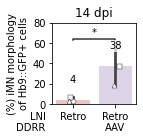

In [17]:
# What to plot
x = 'cond'
y = 'percent_iMN'
size = 'num_total'
order = ['pMXs-LNI', 'pMXs-LNI + AAV-SDDIR']

palette =  {'pMXs-LNI': 'tab:red', 'pMXs-LNI + AAV-SDDIR': 'tab:purple'}
marker_list = ['o', 's', '^', 'D']

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

# Plot iMN yield per MEF plated
g = sns.barplot(
    ax=ax, data=df_morph,
    x=x, y=y, 
    order=order, 
    palette=palette, alpha=0.3)
for (i, rep) in enumerate(df_morph.rep.unique()):
    sns.stripplot(ax=ax, data=df_morph.loc[(df_morph.rep == rep)],
        x=x, y=y, order=order,
        dodge=True, marker=marker_list[i],
        palette={cond: 'white' for cond in order}, size=5,
        edgecolor='black', linewidth=0.4,)

    
# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=15)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))
    

# Pairs for stats comp
pairs = [('pMXs-LNI + AAV-SDDIR', 'pMXs-LNI')]
# Add in stats for iMN yield
annot = Annotator(ax=ax, data=df_morph,
    x=x, y=y, pairs=pairs, order=order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.1)

# Format
plt.title('14 dpi')
ax.yaxis.set_label_text('(%) iMN morphology\nof Hb9::GFP+ cells')
ax.set_yticks(np.arange(0, 100, 20))
ax.set_xlabel('')

df_labels = pd.DataFrame({
    "cond": ['AAV-LNI', 'AAV-LNI + AAV-SDDIR', 'AAV-LNI + pMXs-SDDIR', 'pMXs-LNI', 'pMXs-LNI + AAV-SDDIR'],
    "LNI": ["AAV",  "AAV",   "AAV",  "Retro",    "Retro"],
    "DDRR": ["",    "AAV", "Retro",       "",      "AAV"],
})
rd.plot.generate_xticklabels(df_labels=df_labels, ax_col=x, label_cols=["LNI", "DDRR"], ax=ax)  

# Save
plt.savefig(figpath + 'iMN_morphology_small.svg', bbox_inches='tight')